odict_keys(['module.layer0.0.weight', 'module.layer0.1.weight', 'module.layer0.1.bias', 'module.layer0.1.running_mean', 'module.layer0.1.running_var', 'module.layer0.1.num_batches_tracked', 'module.layer1.0.conv1.weight', 'module.layer1.0.bn1.weight', 'module.layer1.0.bn1.bias', 'module.layer1.0.bn1.running_mean', 'module.layer1.0.bn1.running_var', 'module.layer1.0.bn1.num_batches_tracked', 'module.layer1.0.conv2.weight', 'module.layer1.0.bn2.weight', 'module.layer1.0.bn2.bias', 'module.layer1.0.bn2.running_mean', 'module.layer1.0.bn2.running_var', 'module.layer1.0.bn2.num_batches_tracked', 'module.layer1.0.conv3.weight', 'module.layer1.0.bn3.weight', 'module.layer1.0.bn3.bias', 'module.layer1.0.bn3.running_mean', 'module.layer1.0.bn3.running_var', 'module.layer1.0.bn3.num_batches_tracked', 'module.layer1.0.downsample.0.weight', 'module.layer1.0.downsample.1.weight', 'module.layer1.0.downsample.1.bias', 'module.layer1.0.downsample.1.running_mean', 'module.layer1.0.downsample.1.running_

<Figure size 4000x3000 with 0 Axes>

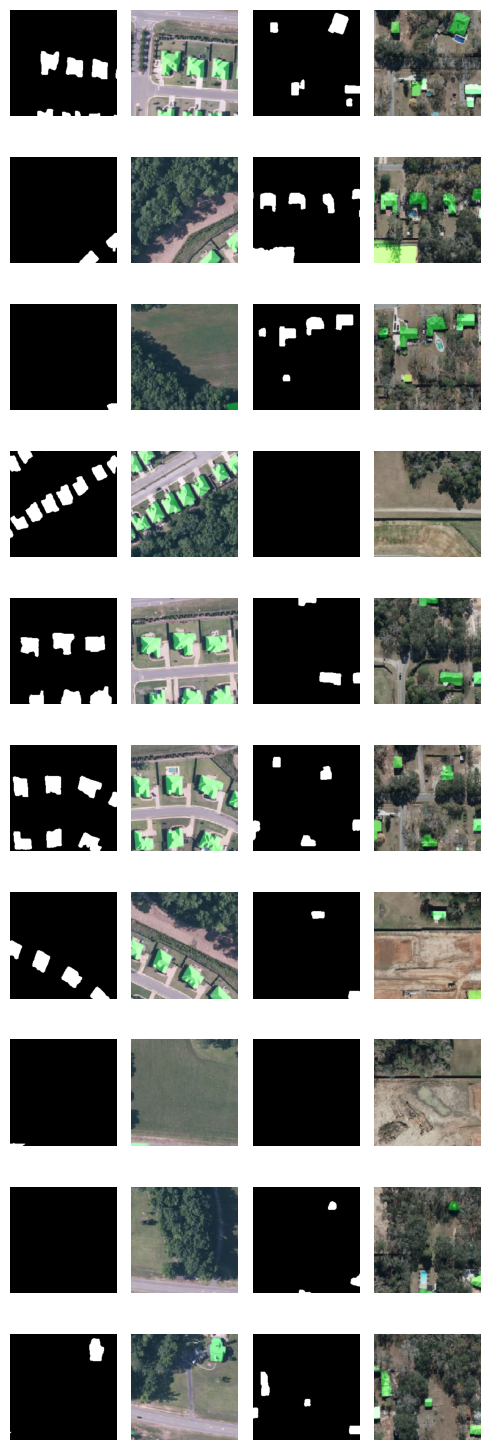

In [4]:
import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from imageio import imsave
from torch.utils import model_zoo
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import ( to_input_image_tensor, add_extra_dimension,
    convert_tensor_to_numpy, load_parallel_model, adjust_model,)
from building_footprint_segmentation.utils.operations import handle_image_size
from natsort import natsorted

plt.figure(figsize=(40,30))

def set_model_weights(pretrained_model_path):
    #MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"
    #state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    #if "model" in state_dict:
    #    state_dict = state_dict["model"]
    #TRAINED_MODEL.load_state_dict(adjust_model(state_dict))
    # 사전 학습된 모델의 상태 딕셔너리를 불러오기
    pretrained_dict = torch.load(pretrained_model_path)
    TRAINED_MODEL.load_state_dict(pretrained_dict)

MAX_SIZE = 224
TRAINED_MODEL = ReFineNet()

def extract(original_image):
    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        prediction = TRAINED_MODEL(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )
    return prediction_binary , prediction_3_channels, dst


def run(image_path, pretrained_model_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    prediction_binary, prediction_3_channels, dst = extract(original_image)#, prediction_3_channels, dst
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    return prediction_binary, prediction_3_channels, dst

def threshold_array(arr, threshold=0.9):
    # 넘파이 배열의 각 요소에 대해 threshold보다 크면 1, 그렇지 않으면 0으로 변환
    return np.where(arr > threshold, 1.0, 0.0)


PRED_PTH = "./test_visualize/"   # 경로 설정 필요
pretrained_model_path = "./out_data/20230725-232144/state/best.pt" # 시각화 할 저장 모델 경로 설정 필요

MAX_SIZE = 224
TRAINED_MODEL = ReFineNet()
#TRAINED_MODEL = DLinkNet34()

# 사전 학습된 모델의 상태 딕셔너리를 불러오기
pretrained_dict = torch.load(pretrained_model_path)["model"]
#print(pretrained_dict)
# 딕셔너리의 키값에서 "module"을 제거하는 함수
def remove_module_from_keys(dictionary):
    new_dict = {}  # 새로운 딕셔너리를 생성하여 수정된 키값을 저장할 준비

    for key, value in dictionary.items():
        new_key = key.replace("module.", "")  # "module_"을 ""로 치환하여 새로운 키값 생성
        new_dict[new_key] = value  # 새로운 키값과 기존 value를 새로운 딕셔너리에 저장

    return new_dict

# "module"을 제거한 새로운 딕셔너리 생성
print(pretrained_dict.keys())

pretrained_dict = remove_module_from_keys(pretrained_dict)

TRAINED_MODEL.load_state_dict(pretrained_dict)
pred_list=[]
print(os.listdir(PRED_PTH))
for ig in natsorted(os.listdir(PRED_PTH)):
    pred_list.append(run(PRED_PTH+"/"+ig, pretrained_model_path))

#print(pred_list)
from PIL import Image
from natsort import natsorted
fig, axes = plt.subplots(len(os.listdir(PRED_PTH))//3, 4, figsize=(5, 15))
for j in range(len(os.listdir(PRED_PTH))):
    if j <10:
        for i in range(3):
            image = pred_list[j][i]
            if i==0:
                continue;
            if i==1:
                image = threshold_array(image)
            axes[j, i-1].imshow(image)  # plt.imshow()를 사용하여 이미지를 시각화
            axes[j, i-1].axis('off')  # 이미지 주변에 눈금 제거
    elif j<20:
        for i in range(3):
            image = pred_list[j][i]
            if i==0:
                continue;
            if i==1:
                image = threshold_array(image)
            axes[j-10, i+1].imshow(image)  # plt.imshow()를 사용하여 이미지를 시각화
            axes[j-10, i+1].axis('off')  # 이미지 주변에 눈금 제거
    else:
        for i in range(3):
            image = pred_list[j][i]
            if i==0:
                continue;
            if i==1:
                image = threshold_array(image)
            axes[j-20, i+1].imshow(image)  # plt.imshow()를 사용하여 이미지를 시각화
            axes[j-20, i+1].axis('off')  # 이미지 주변에 눈금 제거


plt.tight_layout()
plt.show()
#criterion IOU